# Building a Quantum Random Number Generator (QRNG)

Multiple methods are used to build QRNG's in industry and today we will build a primitive one using just one Hadamard Gate, i.e, the [`H Gate`](https://qiskit.org/textbook/ch-states/single-qubit-gates.html#hgate) on a simulator. 

First, let's import what we require from qiskit:

In [8]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# importing Qiskit
from qiskit import IBMQ, BasicAer, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

You can ignore the next two lines of code. This will be required when you want to try the QRNG you build on a real device. We'll get to that later. 

In [9]:
# IBMQ.save_account('YOUR_IBM_TOKEN') # you can find your account id on the IBm Quantum Experience website
                                       # in your profile section 

In [10]:
# provider = IBMQ.load_account()

In [11]:
q2 = QuantumRegister(1)
c2 = ClassicalRegister(1)
qc2 = QuantumCircuit(q2, c2)
qc2.draw()

q1_0: 
      
c1: 1/

Now apply a hadamard gate to put the first qubit into a $|+\rangle$ state. Where, 
$$ |+\rangle = \frac{|0\rangle + |1\rangle}{\sqrt{2}}$$

In [12]:
qc2.h(0)
qc2.draw()

┌───┐
q1_0: ┤ H ├
      └───┘
c1: 1/═════

We only get results when we measure the qubit and then read that clasical data, which in our case is then store in our classical register `c2`.

In [13]:
qc2.measure(q2[0], c2[0])
qc2.draw()

┌───┐┌─┐
q1_0: ┤ H ├┤M├
      └───┘└╥┘
c1: 1/══════╩═
            0

In [34]:
# running and getting results 

backend = Aer.get_backend('qasm_simulator')
job = execute(qc2, backend, shots=1)
# backend = provider.get_backend('ibmq_qasm_simulator')
# job = execute(qc, backend=backend, shots=8000, seed_simulator=12345, backend_options={"fusion_enable":True})
result = job.result()
count = result.get_counts()
print(count)

{'1': 1}


If we re-run the above cell we randomly get the value `0` and `1`. We've created a random number generator!

# Grover's algorithm for 4 qubits (ex: finding the entry 1010)

## Building our circuit and equal superposition initialization

Let's build our circuit with 7 qubits 
* 4 qubits for input
* 1 qubit for storing the |-> state
* 2 ancilla qubits (as will be explained bellow)

And our answer will be stored in a classical register of size 4 

Further, we intialize our input in an equal superposition of all possible states

In [19]:
q = QuantumRegister(7)
c = ClassicalRegister(4)
qc = QuantumCircuit(q, c)

In [20]:
# initialize in a superposition of all possible states 
qc.x(q[4])
qc.h(q[0:5])
qc.barrier(q)

## Complete circuit diagram
source: wikipedia

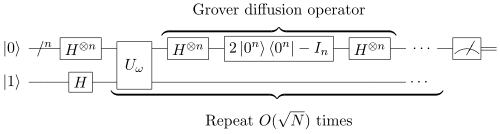

## Let's build the required oracle 

As an example I have built an oracle which check for the state |1010>

The gate named as "mct" is a Multi CNOT gate similar to a generalized CNOT discussed in class. here is it's documentation: https://qiskit.org/documentation/api/qiskit.aqua.circuits.gates.mct.html

We have to use a few ancilla qubits as which tend to follow the rule of "n-2" where "n" is the number of control qubits being used. we need 4 control qubits so we require 2 ancilla qubits. 

Another set of gates being used below are U1, U2 and U3. These are the physical gates that are implementatable on real hardware being provided by IBM Q services. Page 4 of https://arxiv.org/pdf/1807.01703.pdf paper has unitary matrix representation of these gates for your reference. 

In [21]:
qc.barrier(q)

# build oracle. ex: to find 1010 state
qc.x(q[1])
qc.x(q[3])
qc.barrier(q)
qc.mct([q[0], q[1], q[2], q[3]], q[4], q[5:7])    # control qubits, target qubit, ancilla qubits = number of control qubits - 2
qc.barrier(q)
qc.x(q[1])
qc.x(q[3])

qc.barrier(q)

## Amplitude Amplification (Diffusion Operator)

this is equivalent to flip about the mean operation geometrically. Also known as the amplitude amplification step as we are increasing the amplitudes(probability) of the entries that we flipped(gave a - phase to) in the previou step while applying our oracle. 

In [22]:
qc.barrier(q)
qc.h(q[0:4])
qc.barrier(q)
qc.x(q[0:4])
qc.barrier(q)
qc.h(q[3])
qc.barrier(q)
qc.mct([q[0], q[1], q[2]], q[3], q[5:6])   
qc.barrier(q)
qc.h(q[3])
qc.barrier(q)
qc.x(q[0:4])
qc.barrier(q)
qc.h(q[0:4])
qc.barrier(q)


In [23]:
qc.measure(q[0:4], c[0:4])

In [24]:
qc.draw()

# in the output drawing 

┌───┐      ░  ░       ░       ░       ░  ░ ┌───┐ ░ ┌───┐ ░       ░      »
q17_0: ┤ H ├──────░──░───────░───■───░───────░──░─┤ H ├─░─┤ X ├─░───────░───■──»
       ├───┤      ░  ░ ┌───┐ ░   │   ░ ┌───┐ ░  ░ ├───┤ ░ ├───┤ ░       ░   │  »
q17_1: ┤ H ├──────░──░─┤ X ├─░───■───░─┤ X ├─░──░─┤ H ├─░─┤ X ├─░───────░───■──»
       ├───┤      ░  ░ └───┘ ░   │   ░ └───┘ ░  ░ ├───┤ ░ ├───┤ ░       ░   │  »
q17_2: ┤ H ├──────░──░───────░───■───░───────░──░─┤ H ├─░─┤ X ├─░───────░───■──»
       ├───┤      ░  ░ ┌───┐ ░   │   ░ ┌───┐ ░  ░ ├───┤ ░ ├───┤ ░ ┌───┐ ░ ┌─┴─┐»
q17_3: ┤ H ├──────░──░─┤ X ├─░───■───░─┤ X ├─░──░─┤ H ├─░─┤ X ├─░─┤ H ├─░─┤ X ├»
       ├───┤┌───┐ ░  ░ └───┘ ░ ┌─┴─┐ ░ └───┘ ░  ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘»
q17_4: ┤ X ├┤ H ├─░──░───────░─┤ X ├─░───────░──░───────░───────░───────░──────»
       └───┘└───┘ ░  ░       ░ └───┘ ░       ░  ░       ░       ░       ░      »
q17_5: ───────────░──░───────░───────░───────░──░───────░───────░───────░──────»
                  ░  ░       ░       ░       ░  ░       ░       ░       ░      »
q17_6: ───────────░──░───────░───────░───────░──░───────░───────░───────░──────»
                  ░  ░       ░       ░       ░  ░       ░       ░       ░      »
 c3: 4/════════════════════════════════════════════════════════════════════════»
                                                                               »
«        ░       ░ ┌───┐ ░ ┌───┐ ░ ┌─┐         
«q17_0: ─░───────░─┤ X ├─░─┤ H ├─░─┤M├─────────
«        ░       ░ ├───┤ ░ ├───┤ ░ └╥┘┌─┐      
«q17_1: ─░───────░─┤ X ├─░─┤ H ├─░──╫─┤M├──────
«        ░       ░ ├───┤ ░ ├───┤ ░  ║ └╥┘┌─┐   
«q17_2: ─░───────░─┤ X ├─░─┤ H ├─░──╫──╫─┤M├───
«        ░ ┌───┐ ░ ├───┤ ░ ├───┤ ░  ║  ║ └╥┘┌─┐
«q17_3: ─░─┤ H ├─░─┤ X ├─░─┤ H ├─░──╫──╫──╫─┤M├
«        ░ └───┘ ░ └───┘ ░ └───┘ ░  ║  ║  ║ └╥┘
«q17_4: ─░───────░───────░───────░──╫──╫──╫──╫─
«        ░       ░       ░       ░  ║  ║  ║  ║ 
«q17_5: ─░───────░───────░───────░──╫──╫──╫──╫─
«        ░       ░       ░       ░  ║  ║  ║  ║ 
«q17_6: ─░───────░───────░───────░──╫──╫──╫──╫─
«        ░       ░       ░       ░  ║  ║  ║  ║ 
« c3: 4/════════════════════════════╩══╩══╩══╩═
«                                   0  1  2  3

In case you would like to learn more about how the `mct()` gate, i.e, the multiple controlled toffoli gate is decomposed you can check out section [this](https://arxiv.org/pdf/quant-ph/9503016.pdf) paper 

## Checking our results after running it on a simulator

Note that we have not yet used a real quantum computer as they as noisy. We could however do so by changing our provider from 'ibmq_qasm_simulator' to the hardware backend you like. 

In [25]:
# running and getting results 

backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1000)
# backend = provider.get_backend('ibmq_qasm_simulator')
# job = execute(qc, backend=backend, shots=8000, seed_simulator=12345, backend_options={"fusion_enable":True})
result = job.result()
count = result.get_counts()
print(count)

{'0000': 39, '0001': 30, '0010': 22, '0011': 30, '0100': 37, '0101': 481, '0110': 32, '0111': 33, '1000': 34, '1001': 46, '1010': 41, '1011': 41, '1100': 28, '1101': 39, '1110': 33, '1111': 34}


In [26]:
# the code snippet below can be used to retreive your job in case your jupyter notebook loses connection with IBMQ servers before completion of the job

# backend = provider.get_backend('ibmq_qasm_simulator')
# job = backend.retrieve_job('enter your job id here. it can be found in your IBM Q Experience dashboard')
# counts = job.result().get_counts()
# print(counts)

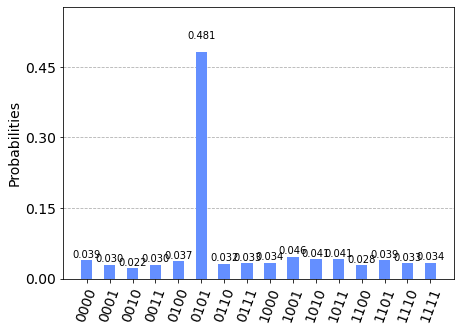

In [27]:
plot_histogram(count)

# the answer may seem inverted, i.e, 0101 is actually state 1010. that's just the notation used by qiskit.

We can see that the entry 1010 has a higher probability of appearing as compared to all the other entries. Note that we have only done the grover method once and yet got a decent answer. I encourage you to try and iterate this method multiple times to see the increase or decrease in probability. For a larger qubit number we may have to do this multiple times to get a decent probability. 

However, if you cross a certain number of iterations the amplitude of the expected states starts to come down again. This is depicted in the link [here](https://www.sciencedirect.com/topics/mathematics/quantum-search-algorithm) through this diagram for 2 and 10 qubits. Thus, the number of iterations $\sqrt{N}$ is usually a good number to stick to in the case of a single search item. If you are searching for "m" items then the number of iterations you'll have to do decreases to $\sqrt{\frac{N}{m}}$.

<img src="grov_2_10.png" width="400px">

### Next Steps? 

Now that we've learnt this algorithm, what types of problems can we tackle? The bet way to learn this is by trying it out yourself. Here are two challenges which are based on Grover's algorithm: 

* [Qiskit Challenge 2019](https://github.com/quantum-challenge/2019/blob/master/problems/final/Final_en.ipynb)      
* [Qiskit Challenge 2020](https://github.com/qiskit-community/IBMQuantumChallenge2020)

Good luck!

Here are a few resources to help you guys out with the problems: 
* [Qiskit Textbook - Grover's algorithm](https://qiskit.org/textbook/ch-algorithms/grover.html)   
* [Textbook chapter 6.4] - Quantum Computing for Computer Scientists (Noson S. Yanofsky, Mirco A. Mannucci)   
* Each of these challenges have their own reading material in their respective Github repos as well 

Once you've solved these problems and are now comfortable with one specific algorithm its time to learn more algorithms from the Qiskit Textbook and possibly start a small project of your own! For project ideas you can check out some of the projects at the recent [Qiskit Korea Hackathon](https://github.com/qiskit-community/qiskit-hackathon-korea-21). You can find them in the `Issues` tab. 

If you're interested in understanding how to design a build qubits at the lowest level, delving into the newly open-sourced [**Qiskit Metal**](https://qiskit.org/metal/) would be the way to go. 

If you would like to understand how to interact with these qubits at the lowest level of pulses and understand how gates are actually applied, you can read up on **Qiskit Pulse** from [Chapter 6.1 of the Qiskit Textbook](https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-pulse.html). 